## Assignment - week 7: Rossmann store sales


This week we will work on a kaggle competition Rossmann store sales. Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

- Objective: predicting daily sales ("Sales" column)
- [Kaggle link](https://www.kaggle.com/c/rossmann-store-sales)
- [Dataset]  (train.csv) 


## 1. Import libraries and take a look at dataset

In [177]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(precision=4)
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = [10, 7]

In [178]:
# Read data
sales = pd.read_csv("./train.csv")

In [179]:
sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


## 2. Exploratory Data Analysis

In [180]:
# Show brief info of our dataset
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [181]:
# Check for null value
sales.isnull().any()

Store            False
DayOfWeek        False
Date             False
Sales            False
Customers        False
Open             False
Promo            False
StateHoliday     False
SchoolHoliday    False
dtype: bool

In [182]:
# How many observations has Sales equal or less than 0
sales[sales.Sales <= 0].shape

(172871, 9)

In [183]:
# Do filter
sales = sales.loc[sales['Sales'] > 0]

In [184]:
# This is a time series dataset so we need Convert "date" column to datetime64 type
# and use this column as index later
sales['Date'] = pd.to_datetime(sales['Date'], format="%Y-%m-%d")

In [185]:
sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


## 3. Preprocessing

In [186]:
# Set date as index
sales = sales.set_index('Date')

# Sort data base on index
sales.sort_index(inplace=True)

# group our data with "pd.Grouper(freq='M')" and sum
# save result in sales_m
sales_m = sales.groupby([pd.Grouper(freq='M')]).sum()

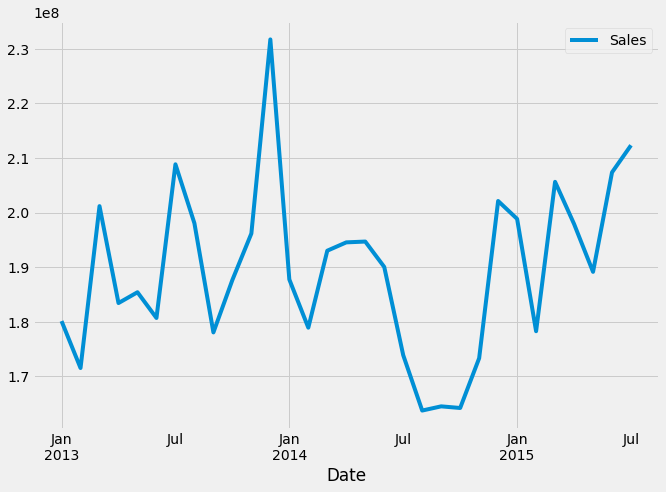

In [187]:
# Let's see how Sales series look like
sales_m.plot(y=['Sales'])

### Objective: Predict sales 

In [188]:
# Take a look at sales_m
sales_m.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
Date,,,,,,,
2013-01-31,16118876,101277,180132207,20380423,28865,11062,3886
2013-02-28,14886979,93735,171534275,19244468,26682,11099,2656
2013-03-31,15561002,100857,201180369,21969462,27891,15558,4576
2013-04-30,15557765,96266,183431432,20882360,27878,13307,4294
2013-05-31,14617034,96167,185411063,20723886,26199,12677,3418


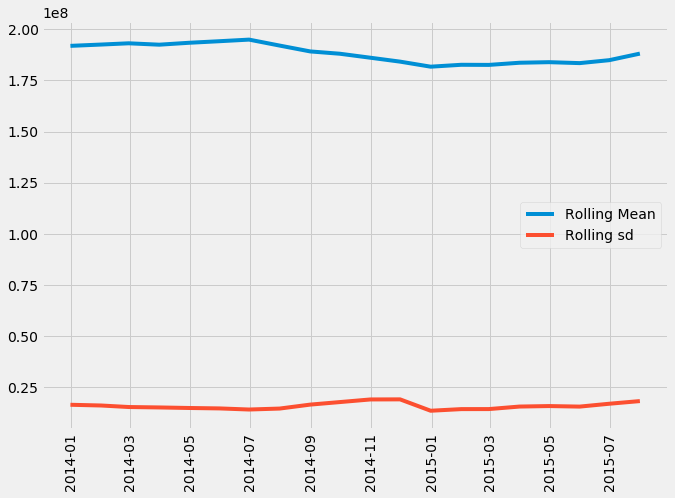

In [189]:
plt.plot(sales_m.Sales.rolling(window=12).mean(), label='Rolling Mean');
plt.plot(sales_m.Sales.rolling(window=12).std(), label="Rolling sd");
plt.xticks(rotation=90)
plt.legend();

Quick observations: There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

Let's check that with a quick decomposition into Trend, seasonality and residuals.

## Decomposing Time Series

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

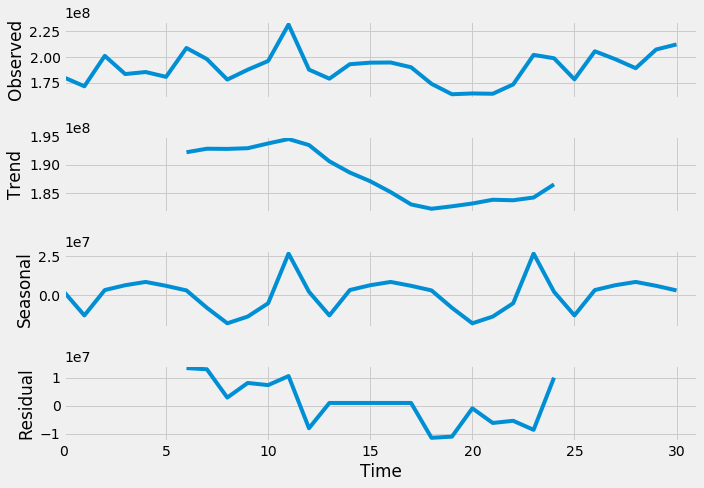

In [190]:
# Import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose Open with freq=12, model='additive'
res = seasonal_decompose(sales_m.Sales.values,freq=12,model="additive")
fig = res.plot();

# Stationarity tests

In [191]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [192]:
# Let's test with original timeseries
test_stationarity(sales_m.Sales.values)

Results of Dickey-Fuller Test:
Test Statistic                 -3.544365
p-value                         0.006918
#Lags Used                      0.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64


In [193]:
# How about we try to de seasonalization our series
# Using diff with periods is 12, the same with season that we can capture from figure
test_stationarity(sales_m.Sales.diff(12).dropna().values)

Results of Dickey-Fuller Test:
Test Statistic                  0.000000
p-value                         0.958532
#Lags Used                      8.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


In [194]:
# Let use diff series with periods is 12 for further steps. Save results in "ts" variable
ts = sales_m.Sales.diff(12).dropna()

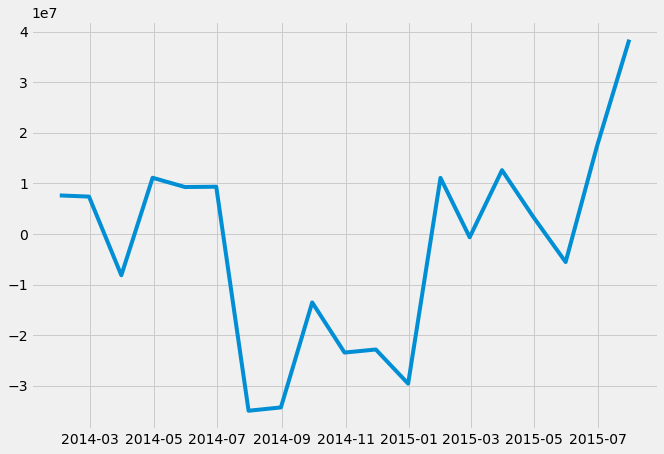

In [195]:
# Let plot and take a look at our series after de-seasonalization
plt.plot(ts);

# 4. Modelling

In [196]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot

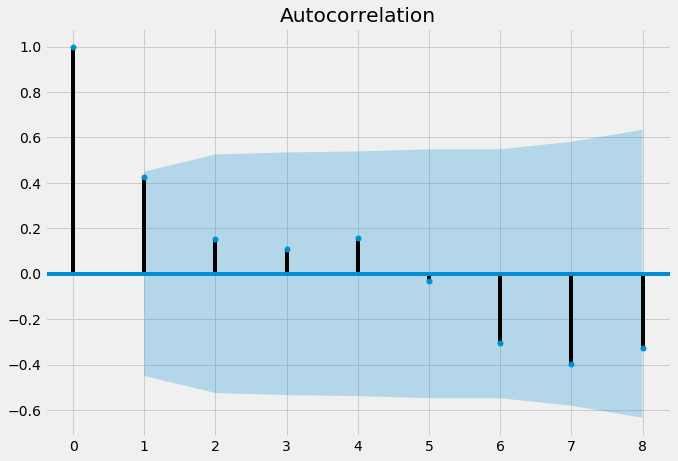

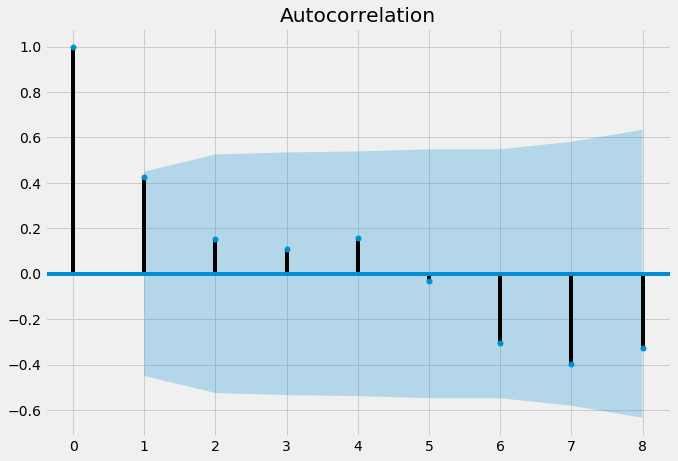

In [197]:
plot_acf(ts, lags=8, alpha=0.05)

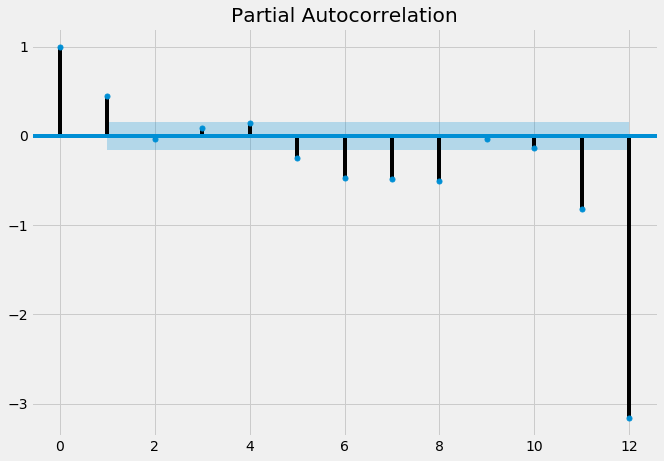

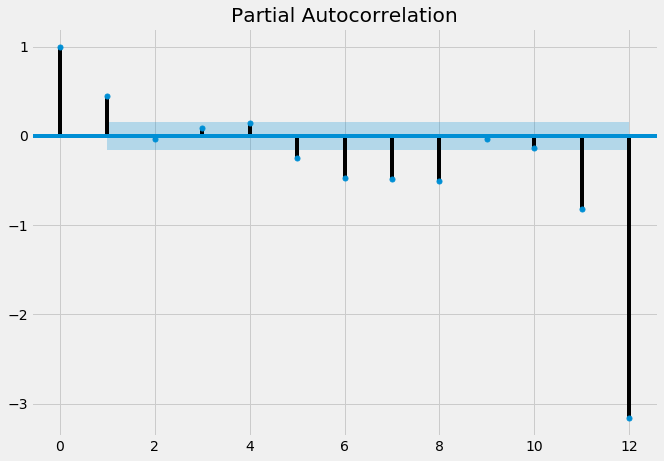

In [198]:
plot_pacf(ts, lags=12, alpha=0.5)

In [199]:
from statsmodels.tsa.arima_model import ARMA
best_aic = np.inf
best_order = None
best_model = None

rng = range(5)
for i in rng:
    for j in rng:
        if i == j == 0:
            continue
        try:
            model = ARMA(ts, order=(i, j)).fit(method='mle', trend='nc')
            aic = model.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (i, j)
                best_model = model
        except: continue
print('AIC: {:6.5} | order: {}'.format(best_aic, best_order))

AIC: 690.11 | order: (1, 0)


## 5. Summary

In [200]:
predict = best_model.predict(start=0, end=25)

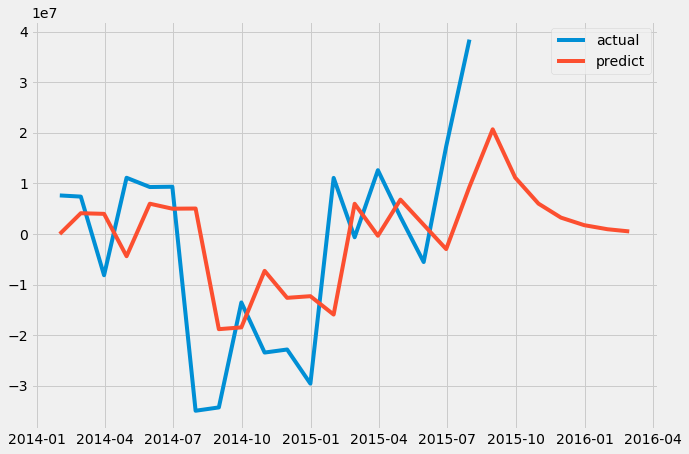

In [201]:
plt.plot(ts, label='actual');
plt.plot(predict, label='predict');
plt.legend()